In [1]:
!pip install spectral
#import argparse
# Loading Drive for Colab
from google.colab import drive
from google.colab import files
## Basics
import gc
gc.collect()
import warnings
warnings.filterwarnings('ignore')
import time
import numpy
import numpy as np
from PIL import Image
from operator import truediv
import scipy.io as sio
import os
import pandas as pd
import seaborn as sns
import spectral
## Ploting
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline
## Sklearn
from sklearn import preprocessing
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.decomposition import PCA
## Deep Model
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Input, concatenate, Dropout, Conv2D, Conv3D, Flatten, Dense, Reshape, Activation, ZeroPadding2D, SeparableConv2D, MaxPooling3D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, GlobalAveragePooling3D
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model

In [2]:
# Mounting the Colab Drive for Loading Datasets
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## Split Training, Validation and Test Sets
def TrTeSplit(HSI, GT, testRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size = testRatio,
                                        random_state = randomState,
                                        stratify = GT)
    return Tr, Te, TrC, TeC

In [4]:
# # https://drive.google.com/file/d/1cyA7sKQlh2c7qrIb7gzexivoyXG8Vie2/view?usp=sharing
# # If the Houston2013 dataset is not downloaded successfully, try running this cell again.
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cyA7sKQlh2c7qrIb7gzexivoyXG8Vie2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cyA7sKQlh2c7qrIb7gzexivoyXG8Vie2" -O Houston2013.zip && rm -rf /tmp/cookies.txt
# !unzip Houston2013.zip

## Downloading (if not avaialbe) and Loading Hyperspectral Datasets
data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/Colab')
HSID = sio.loadmat(os.path.join(data_path, 'ColabHU.mat'))['HSI']
GT = sio.loadmat(os.path.join(data_path, 'ColabHU_gt.mat'))['gt']
Num_Classes = 15

In [5]:
## Global Parameters for Loop
WS = 9
k = 10
adam = tf.keras.optimizers.legacy.Adam(lr = 0.0001, decay = 1e-06)
epochs = 50
batch_size = 256

In [6]:
## 3-D HSI slices
def ImageCubes(HSI, GT, WS = WS, removeZeroLabels = True):
    margin = int((WS - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin = margin)
    ## split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WS, WS, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
## Padding around HSI
def ZeroPad(HSI, margin = 2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI
## Compute the Patch to Prepare for Ground Truths
def Patch(HSI,height_index,width_index):
    height_slice = slice(height_index, height_index+WS)
    width_slice = slice(width_index, width_index+WS)
    patch = HSI[height_slice, width_slice, :]
    return patch

In [7]:
## Assigning Class Labels for Final Classification
def ClassificationReports(TeC, Te_Pred):
    Te_Pred = np.argmax(Te_Pred, axis=1)
    target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    classification = classification_report(np.argmax(TeC, axis=1), Te_Pred, target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), Te_Pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred)
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), Te_Pred)
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

In [8]:
## Main Function to load Datasets, and Creating Patchs for CNN
## Reduce the Dimensionality
start = time.time()
RDHSI = np.reshape(HSID, (-1, HSID.shape[2]))
pca = PCA(n_components = k, whiten = True)
RDHSI = pca.fit_transform(RDHSI)
RDHSI = np.reshape(RDHSI, (HSID.shape[0], HSID.shape[1], k))
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
## Split Train/Validation and Test
Tr, Te, TrC, TeC = TrTeSplit(CRDHSI, CGT, 0.7)
Tr, Va, TrC, VaC = TrTeSplit(Tr, TrC, 0.5)
# Reshape train, validation, and test sets
Tr = Tr.reshape(-1, WS, WS, k, 1)
TrC = to_categorical(TrC)
Va = Va.reshape(-1, WS, WS, k, 1)
VaC = to_categorical(VaC)
Te = Te.reshape(-1, WS, WS, k, 1)
TeC = to_categorical(TeC)

In [9]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

def entry_flow(inputs):
    x = Conv3D(filters=32, kernel_size=(5, 5, 3), activation='relu', padding = 'same')(inputs)
    x = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding = 'same')(x)
    previous_block_activation = x
    for size in [128, 256, 512]:
        x = Conv2Plus1D(filters=size, kernel_size=(3, 3, 3), padding='same')(x)
        x = Conv2Plus1D(filters=size, kernel_size=(3, 3, 3), padding='same')(x)
        x = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
        residual = Conv3D(size, kernel_size=(3, 3, 3), strides = (3, 3, 3), padding = 'same')(previous_block_activation)
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    return x

def middle_flow(x, num_blocks = 8):
    previous_block_activation = x
    for _ in range(num_blocks):
        x = Conv2Plus1D(filters=128, kernel_size=(5, 3, 3), padding='same')(x)
        x = Conv2Plus1D(filters=256, kernel_size=(5, 3, 3), padding='same')(x)
        x = Conv2Plus1D(filters=512, kernel_size=(5, 3, 3), padding='same')(x)
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    return x

def exit_flow(x) :
    previous_block_activation = x
    x = Conv2Plus1D(filters=512, kernel_size=(3, 3, 3), padding='same')(x)
    x = Conv2Plus1D(filters=728, kernel_size=(3, 3, 3), padding='same')(x)
    x = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
    residual = Conv3D(728, kernel_size=(3, 3, 3), padding = 'same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
    x = Conv2Plus1D(filters=512, kernel_size=(3, 3, 3), padding='same')(x)
    x = Conv2Plus1D(filters=256, kernel_size=(3, 3, 3), padding='same')(x)
    x = Dropout(0.4)(x)
    x = GlobalAveragePooling3D()(x)
    x = Dense(Num_Classes, activation='softmax')(x)
    return x

In [10]:
inputs = Input(shape=(WS, WS, k, 1))
inputs.shape
outputs = exit_flow(middle_flow(entry_flow(inputs)))
model = Model(inputs, outputs)
## Compile Model
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
start = time.time()
history = model.fit(Tr, TrC, epochs=epochs, batch_size=batch_size, validation_data=(Va, VaC))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Classification Results
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, Te_Pred)
print(classification)

Epoch 1/50
9/9 [==============================] - 35s 1s/step - loss: 2.7018 - accuracy: 0.0812 - val_loss: 2.6664 - val_accuracy: 0.0439
Epoch 2/50
9/9 [==============================] - 4s 403ms/step - loss: 2.6418 - accuracy: 0.0594 - val_loss: 2.5977 - val_accuracy: 0.1238
Epoch 3/50
9/9 [==============================] - 4s 412ms/step - loss: 2.5218 - accuracy: 0.1389 - val_loss: 2.3105 - val_accuracy: 0.2374
Epoch 4/50
9/9 [==============================] - 4s 462ms/step - loss: 2.1029 - accuracy: 0.2356 - val_loss: 1.8471 - val_accuracy: 0.3549
Epoch 5/50
9/9 [==============================] - 4s 407ms/step - loss: 1.7984 - accuracy: 0.3230 - val_loss: 1.6300 - val_accuracy: 0.3638
Epoch 6/50
9/9 [==============================] - 4s 409ms/step - loss: 1.5696 - accuracy: 0.3957 - val_loss: 1.3637 - val_accuracy: 0.5377
Epoch 7/50
9/9 [==============================] - 4s 466ms/step - loss: 1.3561 - accuracy: 0.4743 - val_loss: 1.1601 - val_accuracy: 0.5577
Epoch 8/50
9/9 [======

                 precision    recall  f1-score   support

  Healthy grass       0.99      0.99      0.99       876
 Stressed grass       1.00      1.00      1.00       878
Synthetic grass       1.00      1.00      1.00       488
          Trees       0.99      0.99      0.99       871
           Soil       0.99      1.00      1.00       869
          Water       1.00      1.00      1.00       227
    Residential       0.99      0.98      0.99       888
     Commercial       1.00      0.99      0.99       871
           Road       0.99      0.95      0.97       876
        Highway       0.96      1.00      0.98       859
        Railway       0.99      0.99      0.99       865
  Parking Lot 1       0.99      1.00      0.99       863
  Parking Lot 2       0.99      0.98      0.99       328
   Tennis Court       1.00      1.00      1.00       300
  Running Track       1.00      1.00      1.00       462

       accuracy                           0.99     10521
      macro avg       0.99   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

470/470 [==============================] - 15s 33ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

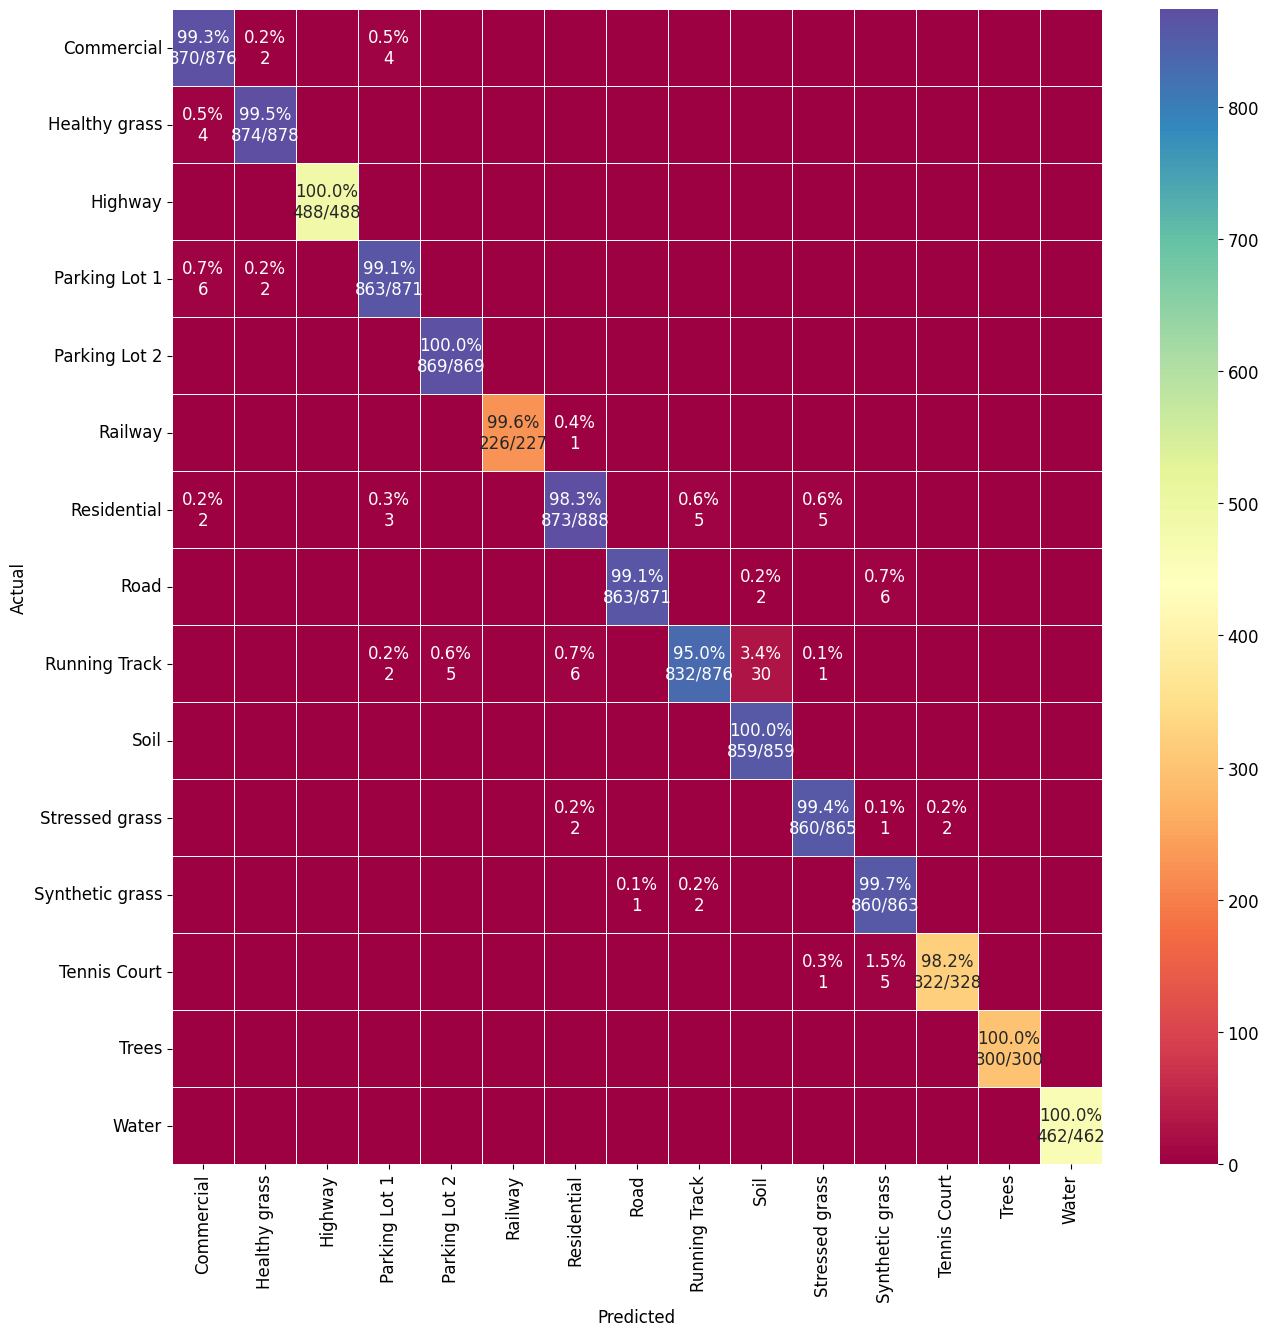

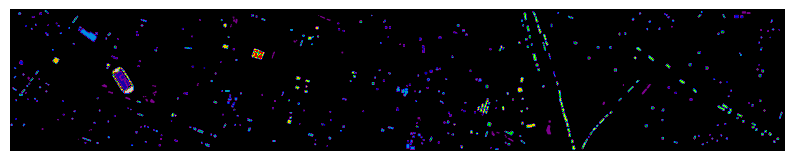

In [12]:
# # Classification Report
# classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, Te_Pred)
# print(classification)
# # file_name = f"str(HSID)+str(teRatio)+str(WS)+str(DLM)+str(k)+Report_{model_name.__name__}.csv"
# file_name = f"{k}_{WS}_Report_HU.csv"
# CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc)
# files.download(file_name)

# # Confusion Matrix
# cm, annot = Conf_Mat(Te_Pred, TeC, target_names)
# cm.index.name = 'Actual'
# cm.columns.name = 'Predicted'
# fig, ax = plt.subplots(figsize=(15,15))
# sns.heatmap(cm, cmap= "Spectral", annot=annot, fmt='', ax=ax, linewidths=0.5)
# file_name = f"{k}_{WS}_Confusion_Matrix.png"
# plt.savefig(file_name, dpi=500)
# files.download(file_name)

# # Ground Truths
# outputs = GT_Plot(CRDHSI, GT, model, WS, k)
# plt.figure(figsize=(10, 10))
# plt.imshow(outputs, cmap='nipy_spectral')
# plt.axis('off')
# file_name = f"{k}_{WS}_Ground_Truths.png"
# plt.savefig(file_name, dpi=500)
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

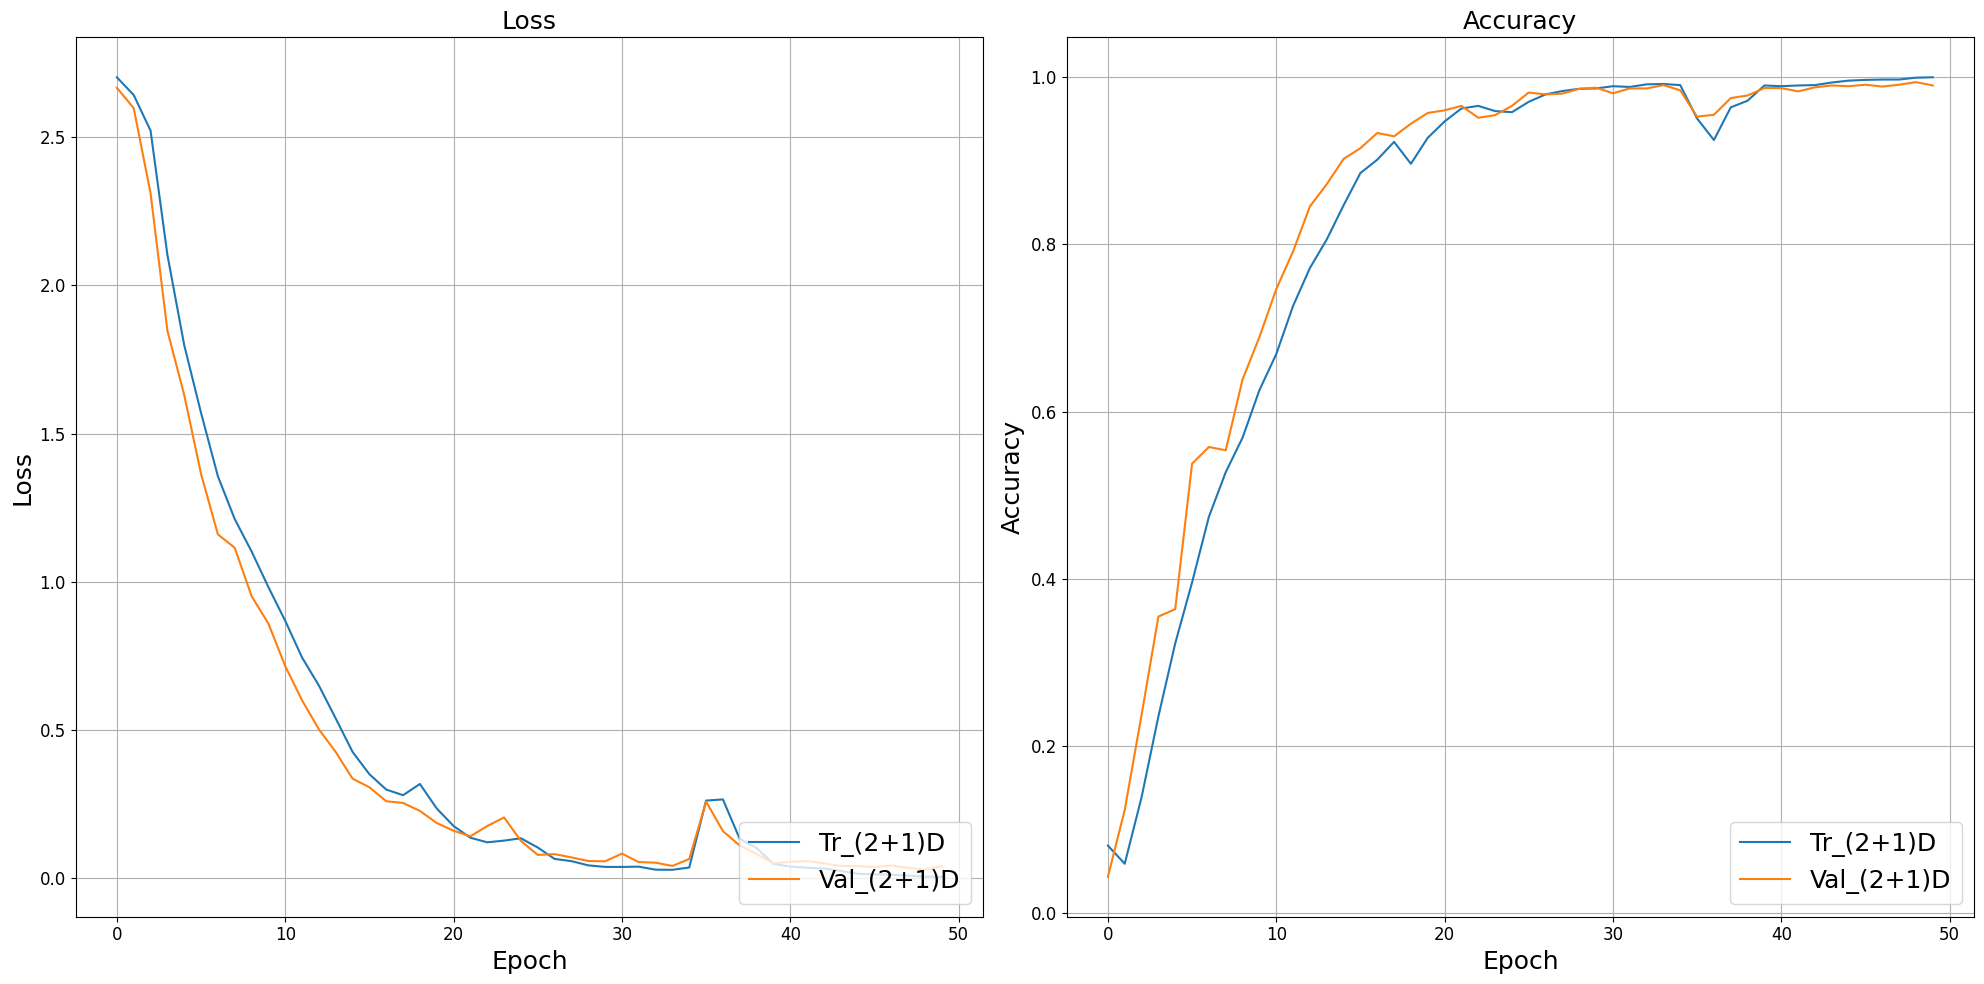

In [13]:
# Plot training and validation loss and accuracy for each model on one graph
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# Plot loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
# Plot accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
# Add labels and legend
axs[0].set_title('Loss', fontsize=18)
axs[0].set_xlabel('Epoch', fontsize=18)
axs[0].set_ylabel('Loss', fontsize=18)
axs[0].legend(['Tr_(2+1)D', 'Val_(2+1)D'], loc='lower right', fontsize=18)
axs[1].set_title('Accuracy', fontsize=18)
axs[1].set_xlabel('Epoch', fontsize=18)
axs[1].set_ylabel('Accuracy', fontsize=18)
axs[1].legend(['Tr_(2+1)D', 'Val_(2+1)D'], loc='lower right', fontsize=18)
# Add grid lines and set background color
axs[0].grid(True)
axs[1].grid(True)
# fig.patch.set_facecolor('#f2f2f2')
plt.tight_layout()
file_name = f"{k}_{WS}_acc_loss_curve_all_models.png"
plt.savefig(file_name, dpi=500)
files.download(file_name)